# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
#  Instlling pillow 5.4.1 as it is throwing the photoshop  variable assignment issue
!pip install Pillow==5.4.1

    100% |████████████████████████████████| 2.0MB 234kB/s eta 0:00:01
  Found existing installation: Pillow 6.0.0
    Uninstalling Pillow-6.0.0:
      Successfully uninstalled Pillow-6.0.0
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
from glob import glob


# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


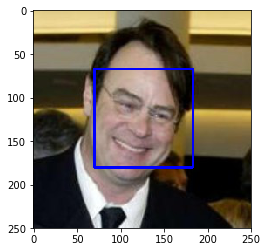

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

Percentage of Number of faces detected in human faces in a batch of 100 images: 98%

Percentage of Number of faces detected in dog faces in a batch of 100 images: 17%

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
c=0
for i in tqdm(human_files_short):
    if face_detector(i):
        c+=1
    
print("Percentage of Number of faces detected in human faces in a batch of 100 images: {}%".format(c))

c=0
for i in tqdm(dog_files_short):
    if face_detector(i):
        c+=1
    
print("Percentage of Number of faces detected in dog faces in a batch of 100 images: {}%".format(c))



  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of Number of faces detected in human faces in a batch of 100 images: 98%


100%|██████████| 100/100 [01:23<00:00,  3.80it/s]

Percentage of Number of faces detected in dog faces in a batch of 100 images: 17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:17<00:00, 32357846.89it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [11]:
from PIL import Image, ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image_transform=transforms.Compose([
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(p=0.02),
                                    transforms.RandomRotation(45),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    
    image= image_transform(Image.open(img_path))
    
    image = image.unsqueeze(0)
    
    if use_cuda:
        image = image.to('cuda')
    
    log_ps = VGG16(image).data.argmax()
    
#     ps = torch.exp(log_ps)
    
#     pred = torch.max(ps, dim=1)
    
#     print(pred[1]) # predicted class index
    
    return log_ps

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    value=VGG16_predict(img_path)
    if(value>=151 and value<=268):
        return True
    else:
        return False
# print(dog_detector(dog_files[100]))
#     if VGG16_predict(img_path) >=151 or VGG16_predict(img_path) <=268:
#             return True # true/false
#     else:
#         return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

Percentage of Number of dog faces detected in human faces: 0.0%

Percentage of Number of dog faces detected in dog faces: 82.0%

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
c=0
for i in tqdm(human_files_short):
    if dog_detector(i):
        c+=1
    
print("Percentage of Number of dog faces detected in human faces: {}%".format((c/len(human_files_short))*100))

c=0
for i in tqdm(dog_files_short):
    if dog_detector(i):
        c+=1
    
print("Percentage of Number of dog faces detected in dog faces: {}%".format((c/len(dog_files_short))*100))

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of Number of dog faces detected in human faces: 0.0%


100%|██████████| 100/100 [01:36<00:00,  1.09it/s]

Percentage of Number of dog faces detected in dog faces: 82.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

## checking the image database
Downgrading the pillow to not use photoshop

In [13]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# Check if CUDA is available
use_cuda = torch.cuda.is_available()

In [14]:
import torchvision.transforms as transforms

# Declare the transforms for train, valid and test sets.
# Imitate the VGG-16 model.
# Resize images because the input size of VGG-16 is 224x224
# Convert to Tensor
# Normalize images because the values of images should be loaded between [0 - 1]

# creating the transforms dict
transforms = {
    
    # Using the random resized crop and horizontalflip to generate data
    'train' : transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'valid' : transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
}

In [15]:
from torchvision import datasets
from torchvision import utils
import os
num_workers = 0
batch_size = 40

# Creating the image_dataset dictionary from the images in /data/dog_images/*
image_datasets = {x: datasets.ImageFolder(os.path.join('/data/dog_images', x), transforms[x])
                 for x in ['train', 'valid', 'test']}

# Data_loaders dictionary
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'valid', 'test']}

# Decreased the test loader size as suggeste in the student community
test_loader = torch.utils.data.DataLoader(image_datasets['test'], shuffle=True,
                                         batch_size=15)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

- The code uses a transform dictionary which save all the three train, valid and test transforms.Read in the PyTorch docmentation about the ideal size to load into the architecture in 256 * 256 and then centrecropping it to 254*254 image. Later normalizing the image so this helps in learning process for a neural network.

- I decided to augment the data as we only have 6680 dataset which doesn't seem to be enough to get the 10% test accuracy so I have added a Random resized crop and a horizontal flip to the training data. and the validation set uses only a reseized centre crop of 224 * 224.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## VGG-16 Architecture
        # Size 224
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Size 112
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # Size 56
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # Size 28
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # Size 14
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # Batch Normalization layers to normalize each layer output so it improves performance
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)
        self.batch_norm512 = nn.BatchNorm2d(512)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 133) # Number logits is 133
    
    # Feedforward
    def forward(self, x):
        x = self.relu(self.batch_norm64(self.conv1_1(x)))
        x = self.relu(self.batch_norm64(self.conv1_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm128(self.conv2_1(x)))
        x = self.relu(self.batch_norm128(self.conv2_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm256(self.conv3_1(x)))
        x = self.relu(self.batch_norm256(self.conv3_2(x)))
        x = self.relu(self.batch_norm256(self.conv3_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv4_1(x)))
        x = self.relu(self.batch_norm512(self.conv4_2(x)))
        x = self.relu(self.batch_norm512(self.conv4_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv5_1(x)))
        x = self.relu(self.batch_norm512(self.conv5_2(x)))
        x = self.relu(self.batch_norm512(self.conv5_3(x)))
        x = self.max_pool(x)
        
        # It returns a new tensor which has a different size
        # and it's the same data of self tensor
        # The -1 means inferring the size from other dimensions.
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Create CNN instance!
model_scratch = Net()

# If CUDA is avaliable, Move Tensors to GPU
if use_cuda:
    model_scratch.cuda()

In [15]:
# Printing the network architechture
print(model_scratch)

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 512,

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have just chosen a random architechture with multiple convolution and maxpooling layers and trained the network it did work well That was not able to achieve 10% Test accuracy it ranged in between 4 and 6 percent.

So After doing some research in the internet I have implemented the VGG architechture.

I was able to obtain a 17% accuracy using this model

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()
### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [16]:
def train(n_epochs, train_loader, valid_loader,
          model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        print("Training in epoch: ",epoch)
        for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate batch loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # parameter update
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
            
        ######################
        # validate the model #
        ######################
        print("validation in epoch: ",epoch)
        for batch_idx, (data, target) in tqdm(enumerate(valid_loader)):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            
            # forward pass
            output = model(data)
            # batch loss
            loss = criterion(output, target)
            # update validation loss
            valid_loss += loss.item() * data.size(0)
        
        # calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        
        # print training/validation statistics 
        print('Epoch: {}\tTraining Loss: {:.6f}\t Validation Loss: {:.6f}'.
             format(epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # return trained model
    return model

In [54]:
n_epochs = 20
# train the model
model_scratch = train(n_epochs, data_loaders['train'], data_loaders['valid'], model_scratch,
                     optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

0it [00:00, ?it/s]

Training in epoch:  1


334it [10:30,  2.08s/it]
0it [00:00, ?it/s]

validation in epoch:  1


42it [00:37,  1.23it/s]


Epoch: 1	Training Loss: 4.869109	 Validation Loss: 4.806888
Validation loss decreased (inf --> 4.806888).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  2


334it [10:30,  2.00s/it]
0it [00:00, ?it/s]

validation in epoch:  2


42it [00:37,  1.24it/s]


Epoch: 2	Training Loss: 4.763065	 Validation Loss: 4.618544
Validation loss decreased (4.806888 --> 4.618544).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  3


334it [10:30,  1.83s/it]
0it [00:00, ?it/s]

validation in epoch:  3


42it [00:37,  1.22it/s]


Epoch: 3	Training Loss: 4.599594	 Validation Loss: 4.440667
Validation loss decreased (4.618544 --> 4.440667).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  4


334it [10:31,  2.07s/it]
0it [00:00, ?it/s]

validation in epoch:  4


42it [00:37,  1.23it/s]


Epoch: 4	Training Loss: 4.461638	 Validation Loss: 4.297973
Validation loss decreased (4.440667 --> 4.297973).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  5


334it [10:32,  1.98s/it]
0it [00:00, ?it/s]

validation in epoch:  5


42it [00:38,  1.07it/s]


Epoch: 5	Training Loss: 4.369995	 Validation Loss: 4.212031
Validation loss decreased (4.297973 --> 4.212031).    Saving model...


334it [10:31,  1.81s/it]
0it [00:00, ?it/s]

Training in epoch:  6
validation in epoch:  6


42it [00:37,  1.17it/s]


Epoch: 6	Training Loss: 4.297682	 Validation Loss: 4.142971
Validation loss decreased (4.212031 --> 4.142971).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  7


334it [10:30,  1.94s/it]
0it [00:00, ?it/s]

validation in epoch:  7


42it [00:37,  1.07it/s]


Epoch: 7	Training Loss: 4.224606	 Validation Loss: 4.055738
Validation loss decreased (4.142971 --> 4.055738).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  8


334it [10:30,  1.90s/it]
0it [00:00, ?it/s]

validation in epoch:  8


42it [00:37,  1.21it/s]


Epoch: 8	Training Loss: 4.143124	 Validation Loss: 3.968306
Validation loss decreased (4.055738 --> 3.968306).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  9


334it [10:30,  1.86s/it]
0it [00:00, ?it/s]

validation in epoch:  9


42it [00:37,  1.31it/s]


Epoch: 9	Training Loss: 4.051673	 Validation Loss: 3.883994
Validation loss decreased (3.968306 --> 3.883994).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  10


334it [10:32,  1.83s/it]
0it [00:00, ?it/s]

validation in epoch:  10


42it [00:37,  1.13it/s]


Epoch: 10	Training Loss: 3.992936	 Validation Loss: 3.786966
Validation loss decreased (3.883994 --> 3.786966).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  11


334it [10:32,  1.85s/it]
0it [00:00, ?it/s]

validation in epoch:  11


42it [00:38,  1.05it/s]


Epoch: 11	Training Loss: 3.927323	 Validation Loss: 3.759553
Validation loss decreased (3.786966 --> 3.759553).    Saving model...


334it [10:31,  1.89s/it]
0it [00:00, ?it/s]

Training in epoch:  12
validation in epoch:  12


42it [00:37,  1.23it/s]


Epoch: 12	Training Loss: 3.876660	 Validation Loss: 3.655200
Validation loss decreased (3.759553 --> 3.655200).    Saving model...


334it [10:32,  2.15s/it]
0it [00:00, ?it/s]

Training in epoch:  13
validation in epoch:  13


42it [00:37,  1.19it/s]


Epoch: 13	Training Loss: 3.807801	 Validation Loss: 3.592223
Validation loss decreased (3.655200 --> 3.592223).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  14


334it [10:32,  1.87s/it]
0it [00:00, ?it/s]

validation in epoch:  14


42it [00:37,  1.34it/s]


Epoch: 14	Training Loss: 3.756200	 Validation Loss: 3.549507
Validation loss decreased (3.592223 --> 3.549507).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  15


334it [10:33,  1.81s/it]
0it [00:00, ?it/s]

validation in epoch:  15


42it [00:38,  1.25it/s]


Epoch: 15	Training Loss: 3.669055	 Validation Loss: 3.502707
Validation loss decreased (3.549507 --> 3.502707).    Saving model...


334it [10:35,  1.84s/it]
0it [00:00, ?it/s]

Training in epoch:  16
validation in epoch:  16


42it [00:37,  1.14it/s]


Epoch: 16	Training Loss: 3.619451	 Validation Loss: 3.396369
Validation loss decreased (3.502707 --> 3.396369).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  17


334it [10:32,  1.83s/it]
0it [00:00, ?it/s]

validation in epoch:  17


42it [00:37,  1.16it/s]


Epoch: 17	Training Loss: 3.561426	 Validation Loss: 3.343890
Validation loss decreased (3.396369 --> 3.343890).    Saving model...


334it [10:28,  1.81s/it]
0it [00:00, ?it/s]

Training in epoch:  18
validation in epoch:  18


42it [00:36,  1.18it/s]


Epoch: 18	Training Loss: 3.470607	 Validation Loss: 3.196131
Validation loss decreased (3.343890 --> 3.196131).    Saving model...


0it [00:00, ?it/s]

Training in epoch:  19


334it [10:27,  1.91s/it]
0it [00:00, ?it/s]

validation in epoch:  19


42it [00:37,  1.13it/s]


Epoch: 19	Training Loss: 3.390107	 Validation Loss: 3.154123
Validation loss decreased (3.196131 --> 3.154123).    Saving model...


334it [10:28,  1.86s/it]
0it [00:00, ?it/s]

Training in epoch:  20
validation in epoch:  20


42it [00:37,  1.23it/s]


Epoch: 20	Training Loss: 3.303003	 Validation Loss: 3.122141
Validation loss decreased (3.154123 --> 3.122141).    Saving model...


In [ ]:
# loads the model_Scratch
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [15]:
def test(loader, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [16]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.112371


Test Accuracy: 21% (180/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [18]:
## TODO: Specify data loaders
# importin the modules
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import utils
import os

# using the same dataloaders created for the model_scratch project
loaders_transfer = data_loaders

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

# Freezing the parameters
for param in model_transfer.parameters():
    param.required_grad = False
    
# Get the input of the last layer of VGG-16
model_transfer.fc = nn.Linear(2048, 133)

for param in model_transfer.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 85930954.09it/s]


In [30]:
# printing the resnet model
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

After a brief research in the internet I start using the resnet50 architechture because of the following points

- Won 1st place in the ILSVRC 2015 classification competition with top-5 error rate of 3.57% (An ensemble model)
- Won the 1st place in ILSVRC and COCO 2015 competition in ImageNet Detection, ImageNet localization, Coco detection and Coco segmentation.
- Replacing VGG-16 layers in Faster R-CNN with ResNet-101. They observed a relative improvements of 28%
- Efficiently trained networks with 100 layers and 1000 layers also.

I have implemented a VGG16 architechtue in the model_scratch so I wanted to test the resnet architechtue as it already has proven results in image classification problems


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [20]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [32]:
# train the model

n_epochs = 20
model_transfer = train(n_epochs, loaders_transfer['train'],loaders_transfer['valid'], model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))


0it [00:00, ?it/s]

Training in epoch:  1



1it [00:02,  2.32s/it]
2it [00:04,  2.21s/it]
3it [00:06,  2.08s/it]
167it [05:34,  2.04s/it]
0it [00:00, ?it/s]

validation in epoch:  1


21it [00:25,  1.26s/it]
0it [00:00, ?it/s]

Epoch: 1	Training Loss: 4.387696	 Validation Loss: 3.656508
Validation loss decreased (inf --> 3.656508).    Saving model...
Training in epoch:  2


167it [05:35,  2.26s/it]
0it [00:00, ?it/s]

validation in epoch:  2


21it [00:25,  1.21s/it]
0it [00:00, ?it/s]

Epoch: 2	Training Loss: 3.384637	 Validation Loss: 2.712700
Validation loss decreased (3.656508 --> 2.712700).    Saving model...
Training in epoch:  3


167it [05:35,  1.89s/it]
0it [00:00, ?it/s]

validation in epoch:  3


21it [00:25,  1.31s/it]
0it [00:00, ?it/s]

Epoch: 3	Training Loss: 2.680125	 Validation Loss: 2.101562
Validation loss decreased (2.712700 --> 2.101562).    Saving model...
Training in epoch:  4


167it [05:40,  1.98s/it]
0it [00:00, ?it/s]

validation in epoch:  4


21it [00:25,  1.21s/it]
0it [00:00, ?it/s]

Epoch: 4	Training Loss: 2.208530	 Validation Loss: 1.678500
Validation loss decreased (2.101562 --> 1.678500).    Saving model...
Training in epoch:  5


167it [05:39,  1.85s/it]
0it [00:00, ?it/s]

validation in epoch:  5


21it [00:25,  1.15s/it]
0it [00:00, ?it/s]

Epoch: 5	Training Loss: 1.884323	 Validation Loss: 1.395621
Validation loss decreased (1.678500 --> 1.395621).    Saving model...
Training in epoch:  6


167it [05:39,  2.20s/it]
0it [00:00, ?it/s]

validation in epoch:  6


21it [00:25,  1.13s/it]
0it [00:00, ?it/s]

Epoch: 6	Training Loss: 1.677877	 Validation Loss: 1.237022
Validation loss decreased (1.395621 --> 1.237022).    Saving model...
Training in epoch:  7


167it [05:38,  2.02s/it]
0it [00:00, ?it/s]

validation in epoch:  7


21it [00:25,  1.38s/it]
0it [00:00, ?it/s]

Epoch: 7	Training Loss: 1.520203	 Validation Loss: 1.096850
Validation loss decreased (1.237022 --> 1.096850).    Saving model...
Training in epoch:  8


167it [05:38,  1.89s/it]
0it [00:00, ?it/s]

validation in epoch:  8


21it [00:25,  1.18s/it]
0it [00:00, ?it/s]

Epoch: 8	Training Loss: 1.382209	 Validation Loss: 0.983544
Validation loss decreased (1.096850 --> 0.983544).    Saving model...
Training in epoch:  9


167it [05:37,  2.15s/it]
0it [00:00, ?it/s]

validation in epoch:  9


21it [00:25,  1.13s/it]
0it [00:00, ?it/s]

Epoch: 9	Training Loss: 1.293864	 Validation Loss: 0.909859
Validation loss decreased (0.983544 --> 0.909859).    Saving model...
Training in epoch:  10


167it [05:35,  2.03s/it]
0it [00:00, ?it/s]

validation in epoch:  10


21it [00:25,  1.15s/it]
0it [00:00, ?it/s]

Epoch: 10	Training Loss: 1.208736	 Validation Loss: 0.835164
Validation loss decreased (0.909859 --> 0.835164).    Saving model...
Training in epoch:  11


167it [05:36,  2.07s/it]
0it [00:00, ?it/s]

validation in epoch:  11


21it [00:25,  1.25s/it]
0it [00:00, ?it/s]

Epoch: 11	Training Loss: 1.171950	 Validation Loss: 0.796742
Validation loss decreased (0.835164 --> 0.796742).    Saving model...
Training in epoch:  12


167it [05:36,  2.08s/it]
0it [00:00, ?it/s]

validation in epoch:  12


21it [00:25,  1.05s/it]
0it [00:00, ?it/s]

Epoch: 12	Training Loss: 1.090910	 Validation Loss: 0.752320
Validation loss decreased (0.796742 --> 0.752320).    Saving model...
Training in epoch:  13


167it [05:36,  2.20s/it]
0it [00:00, ?it/s]

validation in epoch:  13


21it [00:25,  1.05s/it]
0it [00:00, ?it/s]

Epoch: 13	Training Loss: 1.071376	 Validation Loss: 0.722392
Validation loss decreased (0.752320 --> 0.722392).    Saving model...
Training in epoch:  14


167it [05:38,  2.05s/it]
0it [00:00, ?it/s]

validation in epoch:  14


21it [00:25,  1.21s/it]
0it [00:00, ?it/s]

Epoch: 14	Training Loss: 1.037114	 Validation Loss: 0.695764
Validation loss decreased (0.722392 --> 0.695764).    Saving model...
Training in epoch:  15


167it [05:38,  2.21s/it]
0it [00:00, ?it/s]

validation in epoch:  15


21it [00:25,  1.11s/it]
0it [00:00, ?it/s]

Epoch: 15	Training Loss: 0.999726	 Validation Loss: 0.657149
Validation loss decreased (0.695764 --> 0.657149).    Saving model...
Training in epoch:  16


167it [05:38,  2.26s/it]
0it [00:00, ?it/s]

validation in epoch:  16


21it [00:25,  1.09s/it]
0it [00:00, ?it/s]

Epoch: 16	Training Loss: 0.975621	 Validation Loss: 0.653778
Validation loss decreased (0.657149 --> 0.653778).    Saving model...
Training in epoch:  17


167it [05:38,  2.01s/it]
0it [00:00, ?it/s]

validation in epoch:  17


21it [00:25,  1.24s/it]
0it [00:00, ?it/s]

Epoch: 17	Training Loss: 0.945698	 Validation Loss: 0.630646
Validation loss decreased (0.653778 --> 0.630646).    Saving model...
Training in epoch:  18


167it [05:39,  2.06s/it]
0it [00:00, ?it/s]

validation in epoch:  18


21it [00:25,  1.19s/it]
0it [00:00, ?it/s]

Epoch: 18	Training Loss: 0.922732	 Validation Loss: 0.621172
Validation loss decreased (0.630646 --> 0.621172).    Saving model...
Training in epoch:  19


167it [05:37,  1.92s/it]
0it [00:00, ?it/s]

validation in epoch:  19


21it [00:25,  1.25s/it]
0it [00:00, ?it/s]

Epoch: 19	Training Loss: 0.897341	 Validation Loss: 0.591194
Validation loss decreased (0.621172 --> 0.591194).    Saving model...
Training in epoch:  20


167it [05:34,  2.04s/it]
0it [00:00, ?it/s]

validation in epoch:  20


21it [00:25,  1.22s/it]

Epoch: 20	Training Loss: 0.880850	 Validation Loss: 0.581452
Validation loss decreased (0.591194 --> 0.581452).    Saving model...


In [19]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [22]:
test(test_loader, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.698367


Test Accuracy: 82% (693/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [67]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import torchvision.transforms as transforms
from torch.autograd import Variable

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)
    
    image_transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
    
    image = image_transform(image)
    image = image.unsqueeze(0)
    if use_cuda:
        output = model_transfer.forward(Variable(image.cuda())).cpu()
    else:
        output = model_transfer.forward(Variable(image))
    
    value = class_names[output.data.numpy().argmax()]
    return value

In [68]:
value = predict_breed_transfer(dog_files[700])


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [69]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    detect_dog = dog_detector(img_path)
    detect_human = face_detector(img_path)
    
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()
    
    if detect_dog:
        print("Dog detected.\nPredicted breed is {}".format(predict_breed_transfer(img_path)))
        
    elif detect_human:
        print("Human face detected.\nYou look similar to {}".format(predict_breed_transfer(img_path)))
    else:
        print("The model is not able to see a human or a dog in this picture")
    
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The model gave a 82% accuracy on the test data set. The output is not better than expected

1. one imporvement can be to train the model_transfer with more data to get a better accuracy so it can predict better
2. should have trained a model for morethan 20 epochs as it is taking large time for each epoch. udacity workspace time limits. The error could reduce on training the model for more epochs
3. The model did not detect a dog when it is actually a dog this is to be checked


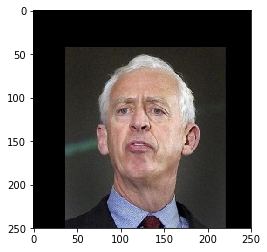

Human face detected.
You look similar to Dachshund


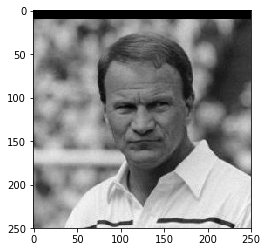

Human face detected.
You look similar to Dachshund


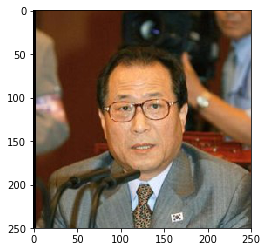

Human face detected.
You look similar to Dachshund


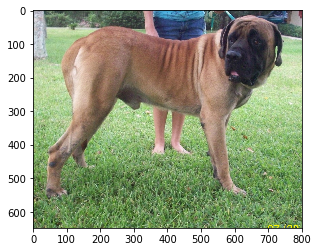

Dog detected.
Predicted breed is Dachshund


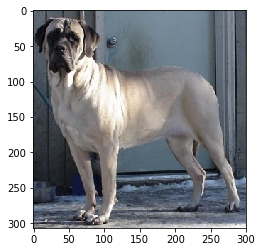

Dog detected.
Predicted breed is Dachshund


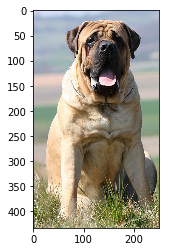

Dog detected.
Predicted breed is Dachshund


In [71]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[3:6], dog_files[:3])):
    run_app(file)